In [6]:
import rasterio
import geopandas as gpd
import pyproj
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from numpy import *
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.metrics import r2_score

In [7]:
def SD_Regression(path, RADAR, RADAR_pred, SI_Mask, FC_Mask, W_Mask, outdir):
    
    i = 0
    for file in os.listdir(path):
        if file.endswith('shp'):

#            filename = file[3:7]
            points = os.path.join(path,file)
            pts = gpd.read_file(points)
            
            if i != 0:
                df_train = pd.concat([df_train,pts])
            else: 
                df_train = pts
                i=i+1           
    
    print('Beams Merged')
    
    df_train['lon'] = df_train.geometry.x
    df_train['lat'] = df_train.geometry.y
    print(df_train)
    #AOI = gpd.read_file('C:/Users/Rasmu/Documents/AOI.shp')
    
    #df_train2 = gpd.clip(df_train, AOI)
    coords = [(x,y) for x, y in zip(df_train.lon, df_train.lat)]

    src = rasterio.open(RADAR)
    src_mask = rasterio.open(SI_Mask)
    src_fc_mask = rasterio.open(FC_Mask)
    src_w_mask = rasterio.open(W_Mask)
    # Sample the raster at every point location and store values in DataFrame
    
    #where_are_NaNs = isnan(src)
    #src[where_are_NaNs] = -999
    print(src,'src')
    
    df_train['RADAR'] = [x[0] for x in src.sample(coords)]
    
    df_train['SI_Mask'] = [x[0] for x in src_mask.sample(coords)]
    df_train['FC_Mask'] = [x[0] for x in src_fc_mask.sample(coords)]
    df_train['W_Mask'] = [x[0] for x in src_w_mask.sample(coords)]
    
    print('Training data ready')
    
    
    df_train = df_train[df_train['SI_Mask'] > 0]
    df_train = df_train[df_train['FC_Mask'] > 0]
    df_train = df_train[df_train['W_Mask'] < 1]
    #df_train = df_train[df_train['ESD_std'] < 4]
    #df_train = df_train[df_train['SLOPE'] != 0]
    #df_train = df_train[df_train['SD'] > 0]
    #df_train = df_train[df_train['SD'] < 5]
    df_train = df_train[df_train['RADAR'] > -22]
    #df_train = df_train[df_train['RADAR'] < -14]
    
    print('Shape of training data ', df_train.shape)
    
    plt.plot(df_train.AT_dist, df_train.SD, 'o', color='black');
    plt.plot(df_train.AT_dist, df_train.RADAR, 'o', color='black');
    plt.plot(df_train.RADAR, df_train.SD, 'o', color='black');

    X = np.array(df_train.RADAR).reshape(-1,1)
    where_are_NaNs = isnan(X)
    X[where_are_NaNs] = 0    
    y = np.array(df_train.SD)
    #reg = LinearRegression().fit(X, y)
    #reg = RandomForestRegressor(max_depth=2, random_state=0).fit(X,y)
    reg = lgbm.LGBMRegressor()
    reg.fit(X, y)
    
    print('Modelled')
    
    with rasterio.open(SI_Mask, 'r') as mask:
        mask_data = mask.read()
        mask_data = np.array(mask_data).reshape(-1,1)
        mask_data = mask_data.flatten()
    with rasterio.open(FC_Mask, 'r') as mask:
        fc_mask_data = mask.read()
        fc_mask_data = np.array(fc_mask_data).reshape(-1,1)
        fc_mask_data = mask_data.flatten()
    
    with rasterio.open(RADAR_pred, 'r') as dataset:
        
        data = dataset.read()
        og_shape = data.shape
        
        data = np.array(data).reshape(-1,1)
        
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = 0
        
        y_pred = reg.predict(data)
        
        print('Predicted')
        
        #y_pred = y_pred.flatten()
        y_pred = y_pred #* mask_data #* fc_mask_data
        profile = dataset.profile
        y_pred = y_pred.reshape(og_shape)
        
        print('Masked')

        y_pred_train = reg.predict(X)
        r2 = str(r2_score(y, y_pred_train).round(2))
        print('R2 score is: ', r2)
        
        with rasterio.open('C:/Users/Rasmu/Documents/Thesis/Regression/31012022_'+r2+'.tif', 'w', **profile) as dst:
            dst.write(y_pred.astype(rasterio.float64))

        
    return df_train

In [14]:
path = 'C:/Users/Rasmu/Documents/Thesis/SD_Rescaled/'
RADAR = 'C://Users/Rasmu/Documents/Thesis/S1_resampled/marts_2020_500m_substract.tif'
RADAR_pred = 'C://Users/Rasmu/Documents/Thesis/S1_resampled/marts_2020_500m_substract.tif'
SI_Mask = 'C:/Users/Rasmu/Documents/Thesis/S2_Masks/SI_Geilo_100m.tif'
FC_Mask = 'C:/Users/Rasmu/Documents/Thesis/S2_Masks/Forest_Cover_Mask.tif'
W_Mask = 'C:/Users/Rasmu/Documents/Thesis/Water_Mask/WATERMASK.tif'
outdir = 'C:/Users/Rasmu/Documents/Thesis/Regression/'

Beams Merged
     AT_dist     SD          lats           lons  \
0    28510.0  2.535  6.719409e+06   49634.140880   
1    28610.0  2.395  6.719399e+06   49631.867464   
2    28710.0  2.400  6.719301e+06   49608.975370   
3    35710.0  2.760  6.712350e+06   48004.742480   
4    35810.0  2.930  6.712350e+06   48004.742480   
..       ...    ...           ...            ...   
252  54100.0  2.080  6.663186e+06  118771.195007   
253  54200.0  2.100  6.663097e+06  118752.697904   
254  54300.0  2.155  6.663097e+06  118752.697904   
255  54400.0  2.150  6.663097e+06  118752.697904   
256  54500.0  2.110  6.662685e+06  118666.956989   

                           geometry            lon           lat  
0     POINT (49634.141 6719409.224)   49634.140880  6.719409e+06  
1     POINT (49631.867 6719399.493)   49631.867464  6.719399e+06  
2     POINT (49608.975 6719301.483)   49608.975370  6.719301e+06  
3     POINT (48004.742 6712349.847)   48004.742480  6.712350e+06  
4     POINT (48004.742 6712

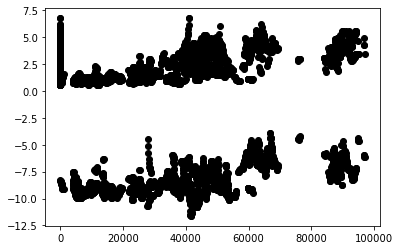

In [15]:
df = SD_Regression(path, RADAR, RADAR_pred, SI_Mask, FC_Mask, W_Mask, outdir)

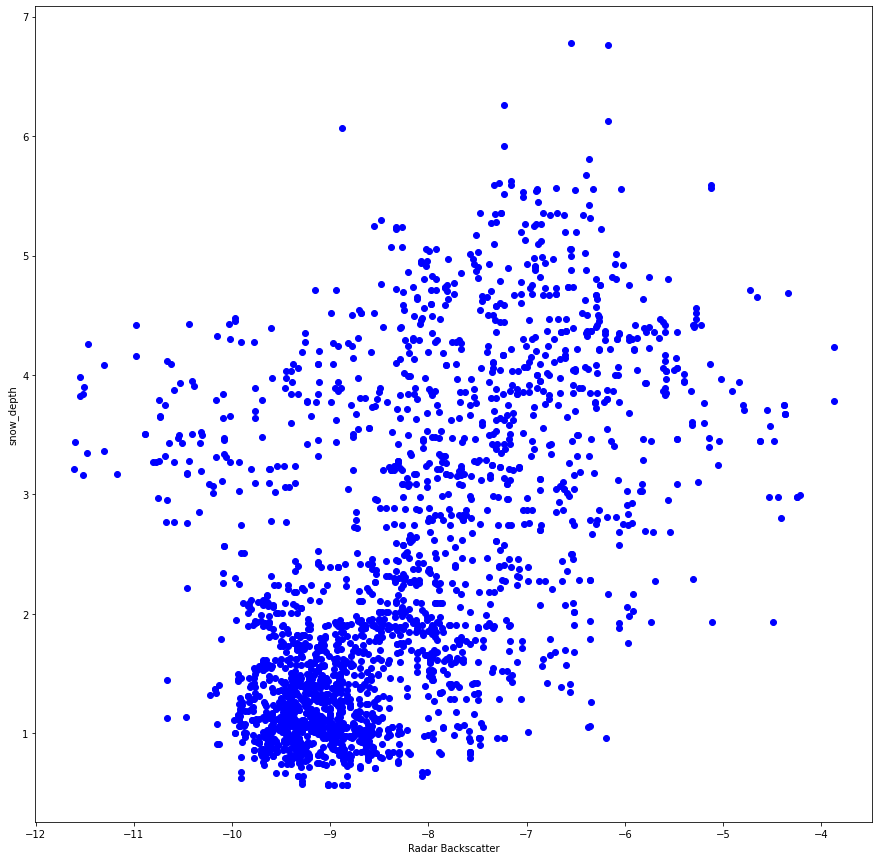

In [16]:
plt.figure(figsize=(15, 15))
plt.xlabel('Radar Backscatter')
plt.ylabel('snow_depth')
#plt.xlim([-1, 5])
plt.scatter(df.RADAR, df.SD, color='blue');